> 2022.05.15 Ssu-Yun Wang<br/>
[Github @angel870326](https://github.com/angel870326)

# **XLNet Multi-class Text Classification for Chinese and English**
Available for both multi-label and single-label classification.

## **Contents**
1. Dataset
   *   Cleaned dataset
   *   Convert 'product' to dummy variables
   *   Get small sample of train and test to try (optional)
<br/>
2. Preprocessing<br/>
   (1) XLNetTokenizer & Sentence embedding<br/>
   (2) Tokenize input texts into ids<br/>
   (3) Create attention masks<br/>
   (4) Add input ids and attention masks to the dataframe<br/>
3. Train, Valid Split<br/>
4. Create Dataloaders (torch tensors)<br/>
5. Training<br/>
   (1) Functions<br/>
   (2) Train model from scratch<br/>
   (3) Train model from previous checkpoint<br/>
6. Get Predictions<br/>
   (1) Testing<br/>
   (2) For single-label classification<br/>
   (3) Save the predicting results<br/>
7. Evaluation<br/>
   (1) Accuracy<br/>
   (2) Precision, Recall & F1<br/>


** Modified from  https://towardsdatascience.com/multi-label-text-classification-with-xlnet-b5f5755302df*

In [1]:
!pip install transformers
# !pip install sentencepiece # for English

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.2 MB 32.3 MB/s 
     |████████████████████████████████| 86 kB 6.5 MB/s 
     |████████████████████████████████| 596 kB 57.5 MB/s 
     |████████████████████████████████| 6.6 MB 49.4 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [2]:
import os
import math
import torch
from torch.nn import CrossEntropyLoss # for single-label
# from torch.nn import BCEWithLogitsLoss # for multi-label
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import AdamW, XLNetTokenizer, XLNetModel, XLNetLMHeadModel, XLNetConfig
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
from tqdm import tqdm, trange
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# GPU
print("GPU Available: {}".format(torch.cuda.is_available()))
n_gpu = torch.cuda.device_count()
print("Number of GPU Available: {}".format(n_gpu))
print("GPU: {}".format(torch.cuda.get_device_name(0)))

GPU Available: True
Number of GPU Available: 1
GPU: Tesla T4


## **1. Dataset**


---



In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Cleaned dataset

In [5]:
train_data = pd.read_csv('/content/drive/MyDrive/碩一下/金融科技/麻布數據/第四組/資料集/category_train.csv')
test = pd.read_csv('/content/drive/MyDrive/碩一下/金融科技/麻布數據/第四組/資料集/category_test.csv')

In [6]:
train_data.head()

,id,name,product
0,60095,6mou ra巴塞利斯 粉晶,滑鼠
1,91788,法國皮爾夏濃索米爾不甜氣泡酒,RTD調酒
2,20692,莫比 mobby 大型成犬配方羊肉米15公斤 狗飼料,狗乾糧罐頭
3,89471,hr奇異果護髮素,護髮乳
4,59587,hp 有線滑鼠,滑鼠


In [7]:
test.head()

,id,name,product
0,70696,舒妃7萃有機草本受損修補菁華,精華液
1,21335,鼎食 晶凍狗罐 雞肉起司 狗副食餐罐,狗乾糧罐頭
2,6331,來復易 防漏安心復健褲成人紙尿褲,成人紙尿褲
3,81149,康乃馨hiwater水濕巾x箱,濕紙巾
4,58515,新樂邁晶球forward雙紫20薄荷菸,菸


### Convert 'product' to dummy variables

In [8]:
train = train_data[['id', 'name']]
products = pd.get_dummies(train_data['product'])
train = pd.concat([train, products], axis=1)
train

,id,name,BB霜,CC霜,DD霜,RTD調酒,中式香腸,乳酸菌,人工淚液,保久乳,...,電磁爐,電視遊戲機,電鍋,電風扇,面膜,面霜/乳霜,香氛機,香氛蠟燭,鮮乳,麥片穀類
0,60095,6mou ra巴塞利斯 粉晶,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,91788,法國皮爾夏濃索米爾不甜氣泡酒,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,20692,莫比 mobby 大型成犬配方羊肉米15公斤 狗飼料,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,89471,hr奇異果護髮素,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,59587,hp 有線滑鼠,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73477,6266,桂格高鐵高鈣奶粉 7倍膠原蛋白罐,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
73478,54887,德國天然什錦水果穀片袋裝,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
73479,76821,比利時alpro經典 原味燕麥奶 全素,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
73480,861,bioneo百妮 玻尿酸保濕化妝水凝露,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Get small sample of train and test to try (optional)

In [ ]:
# train = train.sample(n=1000)
# test = test.sample(n=100)

## **2. Preprocessing**


---



### (1) XLNetTokenizer & Sentence embedding

In [9]:
def plot_sentence_embeddings_length(text_list, tokenizer):
    tokenized_texts = list(map(lambda t: tokenizer.tokenize(t), text_list))
    tokenized_texts_len = list(map(lambda t: len(t), tokenized_texts))
    fig, ax = plt.subplots(figsize=(8, 5));
    ax.hist(tokenized_texts_len, bins=40);
    ax.set_xlabel("Length of Comment Embeddings");
    ax.set_ylabel("Number of Comments");
    return

In [10]:
# XLNetTokenizer (for English)
# tokenizer = XLNetTokenizer.from_pretrained('xlnet-base-cased', do_lower_case=True)

# AutoTokenizer (for Chinese)
from transformers import AutoTokenizer, AutoModel
tokenizer = AutoTokenizer.from_pretrained("hfl/chinese-xlnet-base")

Downloading:   0%|          | 0.00/19.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/671 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/675k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.21M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/202 [00:00<?, ?B/s]

In [11]:
# Texts for classification
train_text_list = train['name'].values
test_text_list = test['name'].values

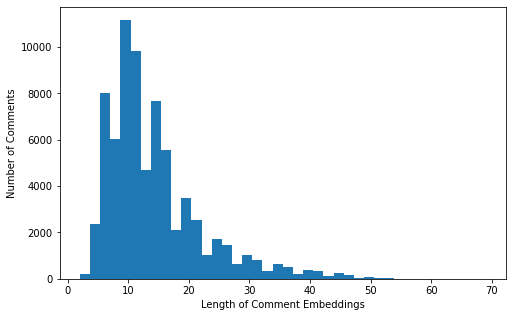

In [12]:
# train
plot_sentence_embeddings_length(train_text_list, tokenizer)

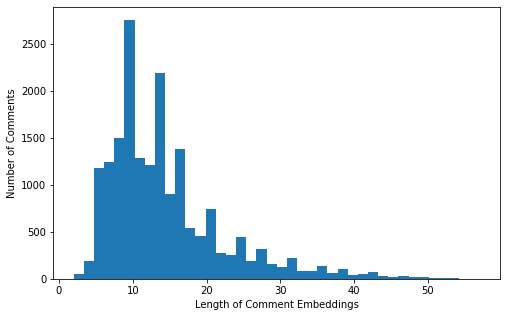

In [13]:
# test
plot_sentence_embeddings_length(test_text_list, tokenizer)

### (2) Tokenize input texts into ids
*   Append the appropriate special characters to the end of the text to denote end of sentence.
*   Truncate or pad the appropriate sequence length.



In [14]:
# 這裡可能要再改
def tokenize_inputs(text_list, tokenizer, num_embeddings=512):
    # tokenize the text, then truncate sequence to the desired length minus 2 for the 2 special characters
    tokenized_texts = list(map(lambda t: tokenizer.tokenize(t)[:num_embeddings-2], text_list))
    # convert tokenized text into numeric ids for the appropriate LM
    input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
    # append special token "<s>" and </s> to end of sentence
    input_ids = [tokenizer.build_inputs_with_special_tokens(x) for x in input_ids]
    # pad sequences
    input_ids = pad_sequences(input_ids, maxlen=num_embeddings, dtype="long", truncating="post", padding="post")
    return input_ids

In [15]:
# Create input id tokens (train)
train_input_ids = tokenize_inputs(train_text_list, tokenizer, num_embeddings=50) # number of embeddings can be modified
train_input_ids

array([[ 3910,  3284,  1507, ...,     0,     0,     0],
       [   19,   928, 16935, ...,     0,     0,     0],
       [ 9323,   146,  6491, ...,     0,     0,     0],
       ...,
       [   19,  7163,   917, ...,     0,     0,     0],
       [ 8439,  4563, 13432, ...,     0,     0,     0],
       [   19,  1627,  5164, ...,     0,     0,     0]])

In [16]:
# Create input id tokens (test)
test_input_ids = tokenize_inputs(test_text_list, tokenizer, num_embeddings=50) # number of embeddings can be modified
test_input_ids

array([[  19, 2763, 3133, ...,    0,    0,    0],
       [  19, 4527,  807, ...,    0,    0,    0],
       [  19,  186, 1802, ...,    0,    0,    0],
       ...,
       [  19,  150, 2405, ...,    0,    0,    0],
       [  19, 5419, 1374, ...,    0,    0,    0],
       [  19,  644, 6224, ...,    0,    0,    0]])

### (3) Create attention masks
*   Tell model whether attention should be applied to the input id tokens.
*   Do not want to perform attention on padding tokens.

In [17]:
def create_attn_masks(input_ids):
    # Create attention masks
    attention_masks = []
    # Create a mask of 1s for each token followed by 0s for padding
    for seq in input_ids:
        seq_mask = [float(i>0) for i in seq]
        attention_masks.append(seq_mask)
    return attention_masks

In [18]:
# Create attention masks
train_attention_masks = create_attn_masks(train_input_ids)
test_attention_masks = create_attn_masks(test_input_ids)

### (4) Add input ids and attention masks to the dataframe

In [19]:
# train
train["features"] = train_input_ids.tolist()
train["masks"] = train_attention_masks
# test
test["features"] = test_input_ids.tolist()
test["masks"] = test_attention_masks

In [20]:
train.head()

,id,name,BB霜,CC霜,DD霜,RTD調酒,中式香腸,乳酸菌,人工淚液,保久乳,...,電鍋,電風扇,面膜,面霜/乳霜,香氛機,香氛蠟燭,鮮乳,麥片穀類,features,masks
0,60095,6mou ra巴塞利斯 粉晶,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"[3910, 3284, 1507, 19, 2901, 227, 632, 6285, 1...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
1,91788,法國皮爾夏濃索米爾不甜氣泡酒,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,"[19, 928, 16935, 752, 8529, 688, 7235, 63, 474...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
2,20692,莫比 mobby 大型成犬配方羊肉米15公斤 狗飼料,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"[9323, 146, 6491, 9445, 8322, 19, 1647, 129, 3...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
3,89471,hr奇異果護髮素,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"[19, 16123, 21168, 984, 2267, 4532, 904, 4, 3,...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
4,59587,hp 有線滑鼠,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"[19, 1141, 1116, 19, 33, 191, 2890, 2902, 19, ...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."


In [21]:
test.head()

,id,name,product,features,masks
0,70696,舒妃7萃有機草本受損修補菁華,精華液,"[19, 2763, 3133, 67, 14762, 11385, 668, 152, 1...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
1,21335,鼎食 晶凍狗罐 雞肉起司 狗副食餐罐,狗乾糧罐頭,"[19, 4527, 807, 19, 4760, 9795, 3033, 9883, 19...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
2,6331,來復易 防漏安心復健褲成人紙尿褲,成人紙尿褲,"[19, 186, 1802, 1272, 19, 1131, 6014, 145, 256...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
3,81149,康乃馨hiwater水濕巾x箱,濕紙巾,"[19, 548, 1603, 13140, 6080, 9558, 2727, 111, ...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
4,58515,新樂邁晶球forward雙紫20薄荷菸,菸,"[2921, 774, 5040, 4760, 368, 15012, 10948, 704...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."


## **3. Train, Valid Split**


---



In [22]:
# train valid split
train, valid = train_test_split(train, test_size=0.2, random_state=42)

In [23]:
X_train = train["features"].values.tolist()
X_valid = valid["features"].values.tolist()

train_masks = train["masks"].values.tolist()
valid_masks = valid["masks"].values.tolist()

# products column names
label_cols = products.columns.values.tolist()
Y_train = train[label_cols].values.tolist()
Y_valid = valid[label_cols].values.tolist()

## **4. Create Dataloaders (torch tensors)**
---

Convert all of the input ids and attention masks into torch tensors, the required datatype for the model.


In [24]:
X_train = torch.tensor(X_train)
X_valid = torch.tensor(X_valid)

Y_train = torch.tensor(Y_train, dtype=torch.float32)
Y_valid = torch.tensor(Y_valid, dtype=torch.float32)

train_masks = torch.tensor(train_masks, dtype=torch.long)
valid_masks = torch.tensor(valid_masks, dtype=torch.long)

In [25]:
# Select a batch size for training
batch_size = 16

# Create an iterator of our data with torch DataLoader. 
# With an iterator, the entire dataset does not need to be loaded into memory.
train_data = TensorDataset(X_train, train_masks, Y_train)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data,\
                              sampler=train_sampler,\
                              batch_size=batch_size)

validation_data = TensorDataset(X_valid, valid_masks, Y_valid)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data,\
                                   sampler=validation_sampler,\
                                   batch_size=batch_size)

## **5. Training**


---



### (1) Functions

Train the model and save the model with the lowest validation loss.

In [26]:
def train(model, num_epochs,\
          optimizer,\
          train_dataloader, valid_dataloader,\
          model_save_path,\
          train_loss_set=[], valid_loss_set = [],\
          lowest_eval_loss=None, start_epoch=0,\
          device="cpu"
          ):
  model.to(device)

  # trange is a tqdm wrapper around the normal python range
  for i in trange(num_epochs, desc="Epoch"):
    # if continue training from saved model
    actual_epoch = start_epoch + i
    """
    Training
    """
    # Set our model to training mode (as opposed to evaluation mode)
    model.train()
    # Tracking variables
    tr_loss = 0
    num_train_samples = 0

    # Train the data for one epoch
    for step, batch in enumerate(train_dataloader):
      # Add batch to GPU
      batch = tuple(t.to(device) for t in batch)
      # Unpack the inputs from our dataloader
      b_input_ids, b_input_mask, b_labels = batch
      # Clear out the gradients (by default they accumulate)
      optimizer.zero_grad()
      # Forward pass
      loss = model(b_input_ids, attention_mask=b_input_mask, labels=b_labels)
      # store train loss
      tr_loss += loss.item()
      num_train_samples += b_labels.size(0)
      # Backward pass
      loss.backward()
      # Update parameters and take a step using the computed gradient
      optimizer.step()
      # scheduler.step()

    # Update tracking variables
    epoch_train_loss = tr_loss/num_train_samples
    train_loss_set.append(epoch_train_loss)
    print("Train loss: {}".format(epoch_train_loss))

    """
    Validation
    """
    # Put model in evaluation mode to evaluate loss on the validation set
    model.eval()
    # Tracking variables 
    eval_loss = 0
    num_eval_samples = 0

    # Evaluate data for one epoch
    for batch in valid_dataloader:
      # Add batch to GPU
      batch = tuple(t.to(device) for t in batch)
      # Unpack the inputs from our dataloader
      b_input_ids, b_input_mask, b_labels = batch
      # Telling the model not to compute or store gradients,
      # saving memory and speeding up validation
      with torch.no_grad():
        # Forward pass, calculate validation loss
        loss = model(b_input_ids, attention_mask=b_input_mask, labels=b_labels)
        # store valid loss
        eval_loss += loss.item()
        num_eval_samples += b_labels.size(0)

    # Update tracking variables
    epoch_eval_loss = eval_loss/num_eval_samples
    valid_loss_set.append(epoch_eval_loss)
    print("Valid loss: {}".format(epoch_eval_loss))

    if lowest_eval_loss == None:
      lowest_eval_loss = epoch_eval_loss
      # save model
      save_model(model, model_save_path, actual_epoch,\
                 lowest_eval_loss, train_loss_set, valid_loss_set)
    else:
      if epoch_eval_loss < lowest_eval_loss:
        lowest_eval_loss = epoch_eval_loss
        # save model
        save_model(model, model_save_path, actual_epoch,\
                   lowest_eval_loss, train_loss_set, valid_loss_set)
    print("\n")

  return model, train_loss_set, valid_loss_set

Save the model to the path directory provided.

In [27]:
def save_model(model, save_path, epochs, lowest_eval_loss, train_loss_hist, valid_loss_hist):
  model_to_save = model.module if hasattr(model, 'module') else model
  checkpoint = {'epochs': epochs, \
                'lowest_eval_loss': lowest_eval_loss,\
                'state_dict': model_to_save.state_dict(),\
                'train_loss_hist': train_loss_hist,\
                'valid_loss_hist': valid_loss_hist
               }
  torch.save(checkpoint, save_path)
  print("Saving model at epoch {} with validation loss of {}".format(epochs,\
                                                                     lowest_eval_loss))
  return

Load the model from the path directory provided.

In [28]:
def load_model(save_path):
  checkpoint = torch.load(save_path)
  model_state_dict = checkpoint['state_dict']
  model = XLNetForMultiLabelSequenceClassification(num_labels=model_state_dict["classifier.weight"].size()[0])
  model.load_state_dict(model_state_dict)

  epochs = checkpoint["epochs"]
  lowest_eval_loss = checkpoint["lowest_eval_loss"]
  train_loss_hist = checkpoint["train_loss_hist"]
  valid_loss_hist = checkpoint["valid_loss_hist"]
  
  return model, epochs, lowest_eval_loss, train_loss_hist, valid_loss_hist

### (2) Train model from scratch

In [29]:
torch.cuda.empty_cache()

In [30]:
#config = XLNetConfig()
        
class XLNetForMultiLabelSequenceClassification(torch.nn.Module):
  
  def __init__(self, num_labels=2):
    super(XLNetForMultiLabelSequenceClassification, self).__init__()
    self.num_labels = num_labels
    # self.xlnet = XLNetModel.from_pretrained('xlnet-base-cased') # for English
    self.xlnet = AutoModel.from_pretrained("hfl/chinese-xlnet-base") # for Chinese
    self.classifier = torch.nn.Linear(768, num_labels)

    torch.nn.init.xavier_normal_(self.classifier.weight)

  def forward(self, input_ids, token_type_ids=None,\
              attention_mask=None, labels=None):
    # last hidden layer
    last_hidden_state = self.xlnet(input_ids=input_ids,\
                                   attention_mask=attention_mask,\
                                   token_type_ids=token_type_ids)
    # pool the outputs into a mean vector
    mean_last_hidden_state = self.pool_hidden_state(last_hidden_state)
    logits = self.classifier(mean_last_hidden_state)
        
    if labels is not None:
      loss_fct = CrossEntropyLoss() # for single-label
      # loss_fct = BCEWithLogitsLoss() # for multi-label
      loss = loss_fct(logits.view(-1, self.num_labels),\
                      labels.view(-1, self.num_labels))
      return loss
    else:
      return logits
    
  def freeze_xlnet_decoder(self):
    """
    Freeze XLNet weight parameters. They will not be updated during training.
    """
    for param in self.xlnet.parameters():
      param.requires_grad = False
    
  def unfreeze_xlnet_decoder(self):
    """
    Unfreeze XLNet weight parameters. They will be updated during training.
    """
    for param in self.xlnet.parameters():
      param.requires_grad = True
    
  def pool_hidden_state(self, last_hidden_state):
    """
    Pool the output vectors into a single mean vector 
    """
    last_hidden_state = last_hidden_state[0]
    mean_last_hidden_state = torch.mean(last_hidden_state, 1)
    return mean_last_hidden_state
    
model = XLNetForMultiLabelSequenceClassification(num_labels=len(Y_train[0]))
#model = torch.nn.DataParallel(model)
#model.cuda()

Downloading:   0%|          | 0.00/445M [00:00<?, ?B/s]

Some weights of the model checkpoint at hfl/chinese-xlnet-base were not used when initializing XLNetModel: ['lm_loss.weight', 'lm_loss.bias']
- This IS expected if you are initializing XLNetModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [31]:
optimizer = AdamW(model.parameters(), lr=2e-5, weight_decay=0.01, correct_bias=False)
# scheduler = WarmupLinearSchedule(optimizer, warmup_steps=num_warmup_steps, t_total=num_total_steps)  # PyTorch scheduler

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


In [34]:
# Need GPU
# Modify output path

num_epochs=3

cwd = os.getcwd()
model_save_path = output_model_file = os.path.join(cwd, "/content/drive/MyDrive/碩一下/金融科技/麻布數據/第四組/model/xlnet_product_train_single.bin")
model, train_loss_set, valid_loss_set = train(model=model,\
                                              num_epochs=num_epochs,\
                                              optimizer=optimizer,\
                                              train_dataloader=train_dataloader,\
                                              valid_dataloader=validation_dataloader,\
                                              model_save_path=model_save_path,\
                                              device="cuda")

Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Train loss: 0.139704677502383
Valid loss: 0.009841086794041156


Epoch:  33%|███▎      | 1/3 [11:55<23:50, 715.45s/it]

Saving model at epoch 0 with validation loss of 0.009841086794041156


Train loss: 0.00688634931414999
Valid loss: 0.006173482929099044


Epoch:  67%|██████▋   | 2/3 [23:49<11:54, 714.58s/it]

Saving model at epoch 1 with validation loss of 0.006173482929099044


Train loss: 0.0037798747018267438


Epoch: 100%|██████████| 3/3 [35:42<00:00, 714.00s/it]

Valid loss: 0.007837278288796639




Text(0.5, 1.0, 'Loss vs Number of Epochs')

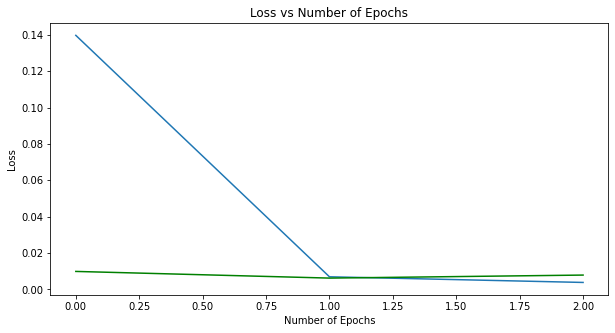

In [35]:
# Plot loss
num_epochs = np.arange(len(train_loss_set))

fig, ax = plt.subplots(figsize=(10, 5));
ax.plot(num_epochs, np.array(train_loss_set), label="Train Loss")
ax.plot(num_epochs, np.array(valid_loss_set), 'g-', label="Valid Loss")
# ax1.plot(episode_record, lose_record, 'r-', label="Lose %")
ax.set_xlabel("Number of Epochs")
ax.set_ylabel("Loss")
ax.set_title("Loss vs Number of Epochs")

### (3) Train model from previous checkpoint

In [36]:
cwd = os.getcwd()
model_save_path = output_model_file = os.path.join(cwd, "/content/drive/MyDrive/碩一下/金融科技/麻布數據/第四組/model/xlnet_product_train_single.bin")
model, start_epoch, lowest_eval_loss, train_loss_hist, valid_loss_hist = load_model(model_save_path)

Some weights of the model checkpoint at hfl/chinese-xlnet-base were not used when initializing XLNetModel: ['lm_loss.weight', 'lm_loss.bias']
- This IS expected if you are initializing XLNetModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [37]:
optimizer = AdamW(model.parameters(), lr=2e-5, weight_decay=0.01, correct_bias=False)

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


In [38]:
num_epochs=3
model, train_loss_set, valid_loss_set = train(model=model,\
                                              num_epochs=num_epochs,\
                                              optimizer=optimizer,\
                                              train_dataloader=train_dataloader,\
                                              valid_dataloader=validation_dataloader,\
                                              model_save_path=model_save_path,\
                                              train_loss_set=train_loss_hist,\
                                              valid_loss_set=valid_loss_hist,\
                                              lowest_eval_loss=lowest_eval_loss,\
                                              start_epoch=start_epoch,\
                                              device="cuda")

Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Train loss: 0.004974806157846678
Valid loss: 0.005172562227314926


Epoch:  33%|███▎      | 1/3 [11:53<23:46, 713.33s/it]

Saving model at epoch 1 with validation loss of 0.005172562227314926


Train loss: 0.0024022779989311084


Epoch:  67%|██████▋   | 2/3 [23:46<11:53, 713.18s/it]

Valid loss: 0.006286580344018544


Train loss: 0.0017875844725542586
Valid loss: 0.005022627053698958


Epoch: 100%|██████████| 3/3 [35:39<00:00, 713.28s/it]

Saving model at epoch 3 with validation loss of 0.005022627053698958




Text(0.5, 1.0, 'Loss vs Number of Epochs')

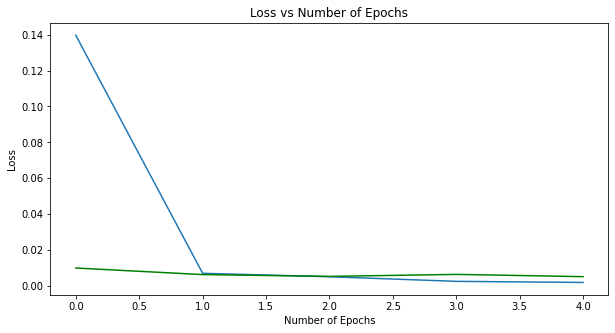

In [39]:
# Plot loss
num_epochs = np.arange(len(train_loss_set))

fig, ax = plt.subplots(figsize=(10, 5));
ax.plot(num_epochs, np.array(train_loss_set), label="Train Loss")
ax.plot(num_epochs, np.array(valid_loss_set), 'g-', label="Valid Loss")
# ax1.plot(episode_record, lose_record, 'r-', label="Lose %")
ax.set_xlabel("Number of Epochs")
ax.set_ylabel("Loss")
ax.set_title("Loss vs Number of Epochs")

## **6. Get Predictions**


---



### (1) Testing

In [40]:
def generate_predictions(model, df, num_labels, device="cpu", batch_size=32):
  num_iter = math.ceil(df.shape[0]/batch_size)
  
  pred_probs = np.array([]).reshape(0, num_labels)
  
  model.to(device)
  model.eval()
  
  for i in range(num_iter):
    df_subset = df.iloc[i*batch_size:(i+1)*batch_size,:]
    X = df_subset["features"].values.tolist()
    masks = df_subset["masks"].values.tolist()
    X = torch.tensor(X)
    masks = torch.tensor(masks, dtype=torch.long)
    X = X.to(device)
    masks = masks.to(device)
    with torch.no_grad():
      logits = model(input_ids=X, attention_mask=masks)
      logits = logits.sigmoid().detach().cpu().numpy()
      pred_probs = np.vstack([pred_probs, logits])
  
  return pred_probs

In [41]:
num_labels = len(label_cols)
pred_probs = generate_predictions(model, test, num_labels, device="cuda", batch_size=32)
pred_probs

array([[0.12302548, 0.33148506, 0.00470616, ..., 0.28269321, 0.63999611,
        0.90905571],
       [0.02021298, 0.77878749, 0.08098984, ..., 0.00558428, 0.40670958,
        0.98532283],
       [0.26346022, 0.93317199, 0.00519354, ..., 0.01915395, 0.41871539,
        0.19076072],
       ...,
       [0.06181319, 0.3459416 , 0.41801241, ..., 0.9968816 , 0.04759509,
        0.98832464],
       [0.58658266, 0.03220887, 0.98923457, ..., 0.75622737, 0.86412686,
        0.00170734],
       [0.01563036, 0.04580117, 0.08660793, ..., 0.15978697, 0.55360013,
        0.05047944]])

In [42]:
for i in label_cols:
  test[i] = pred_probs[:,label_cols.index(i)]

test.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  


,id,name,product,features,masks,BB霜,CC霜,DD霜,RTD調酒,中式香腸,...,電磁爐,電視遊戲機,電鍋,電風扇,面膜,面霜/乳霜,香氛機,香氛蠟燭,鮮乳,麥片穀類
0,70696,舒妃7萃有機草本受損修補菁華,精華液,"[19, 2763, 3133, 67, 14762, 11385, 668, 152, 1...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",0.123025,0.331485,0.004706,0.173300,0.676995,...,0.331881,0.338672,0.792999,0.251307,0.445830,0.948902,0.743654,0.282693,0.639996,0.909056
1,21335,鼎食 晶凍狗罐 雞肉起司 狗副食餐罐,狗乾糧罐頭,"[19, 4527, 807, 19, 4760, 9795, 3033, 9883, 19...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",0.020213,0.778787,0.080990,0.483743,0.121335,...,0.459295,0.665848,0.066474,0.398064,0.015710,0.009291,0.178849,0.005584,0.406710,0.985323
2,6331,來復易 防漏安心復健褲成人紙尿褲,成人紙尿褲,"[19, 186, 1802, 1272, 19, 1131, 6014, 145, 256...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",0.263460,0.933172,0.005194,0.003415,0.700050,...,0.478297,0.906340,0.072085,0.368292,0.945712,0.006618,0.314972,0.019154,0.418715,0.190761
3,81149,康乃馨hiwater水濕巾x箱,濕紙巾,"[19, 548, 1603, 13140, 6080, 9558, 2727, 111, ...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",0.377621,0.792005,0.060526,0.026631,0.231564,...,0.591576,0.780061,0.666340,0.057401,0.593207,0.994048,0.344368,0.007752,0.878585,0.227909
4,58515,新樂邁晶球forward雙紫20薄荷菸,菸,"[2921, 774, 5040, 4760, 368, 15012, 10948, 704...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",0.037782,0.003969,0.039755,0.833859,0.865454,...,0.992715,0.579996,0.016959,0.755694,0.293800,0.956369,0.847807,0.663306,0.000123,0.918000


### (2) For single-label classification

In [43]:
# Get the maximum probability for each row
test['product_predict'] = test.iloc[:,5:].idxmax(axis = 1)
test

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  


,id,name,product,features,masks,BB霜,CC霜,DD霜,RTD調酒,中式香腸,...,電視遊戲機,電鍋,電風扇,面膜,面霜/乳霜,香氛機,香氛蠟燭,鮮乳,麥片穀類,product_predict
0,70696,舒妃7萃有機草本受損修補菁華,精華液,"[19, 2763, 3133, 67, 14762, 11385, 668, 152, 1...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",0.123025,0.331485,0.004706,0.173300,0.676995,...,0.338672,0.792999,0.251307,0.445830,0.948902,0.743654,0.282693,0.639996,0.909056,精華液
1,21335,鼎食 晶凍狗罐 雞肉起司 狗副食餐罐,狗乾糧罐頭,"[19, 4527, 807, 19, 4760, 9795, 3033, 9883, 19...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",0.020213,0.778787,0.080990,0.483743,0.121335,...,0.665848,0.066474,0.398064,0.015710,0.009291,0.178849,0.005584,0.406710,0.985323,狗乾糧罐頭
2,6331,來復易 防漏安心復健褲成人紙尿褲,成人紙尿褲,"[19, 186, 1802, 1272, 19, 1131, 6014, 145, 256...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",0.263460,0.933172,0.005194,0.003415,0.700050,...,0.906340,0.072085,0.368292,0.945712,0.006618,0.314972,0.019154,0.418715,0.190761,成人紙尿褲
3,81149,康乃馨hiwater水濕巾x箱,濕紙巾,"[19, 548, 1603, 13140, 6080, 9558, 2727, 111, ...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",0.377621,0.792005,0.060526,0.026631,0.231564,...,0.780061,0.666340,0.057401,0.593207,0.994048,0.344368,0.007752,0.878585,0.227909,濕紙巾
4,58515,新樂邁晶球forward雙紫20薄荷菸,菸,"[2921, 774, 5040, 4760, 368, 15012, 10948, 704...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",0.037782,0.003969,0.039755,0.833859,0.865454,...,0.579996,0.016959,0.755694,0.293800,0.956369,0.847807,0.663306,0.000123,0.918000,菸
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18366,24044,osim按摩椅,按摩椅,"[19, 3846, 3233, 1369, 1228, 10382, 4, 3, 0, 0...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, ...",0.042729,0.666160,0.401980,0.492861,0.989312,...,0.979804,0.006153,0.044364,0.207078,0.004228,0.047261,0.111747,0.012606,0.885115,按摩椅
18367,63715,nike flx vent max 男子 黑色 排汗 快乾 訓練 運動 長褲 cj2219,運動/機能服,"[19, 629, 13579, 19, 17420, 1309, 19, 20595, 6...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",0.074125,0.924350,0.056893,0.008016,0.072553,...,0.191542,0.049733,0.132635,0.062670,0.931896,0.188227,0.135766,0.199352,0.920884,運動/機能服
18368,50969,solone單色眼影,眼影盤,"[19, 150, 2405, 5653, 796, 569, 931, 1519, 4, ...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",0.061813,0.345942,0.418012,0.955114,0.855875,...,0.978855,0.083122,0.177540,0.950371,0.041368,0.907815,0.996882,0.047595,0.988325,眼影盤
18369,44568,恆久完美特霧氣墊粉餅,粉餅,"[19, 5419, 1374, 7603, 92, 5706, 894, 17216, 2...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",0.586583,0.032209,0.989235,0.296861,0.907269,...,0.044016,0.907060,0.964968,0.033872,0.627419,0.111837,0.756227,0.864127,0.001707,粉餅


### (3) Save the predicting results

In [44]:
cwd = os.getcwd()
pred_save_path = output_model_file = os.path.join(cwd, "/content/drive/MyDrive/碩一下/金融科技/麻布數據/第四組/output/product_train_single_1_epoch.csv")
test.to_csv(pred_save_path, index=False)

## **7. Evaluation**


---



In [45]:
y_test = test['product']
y_predict = test['product_predict']

### (1) Accuracy

In [46]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_predict)

0.9869903652495782

### (2) Precision, Recall & F1

In [47]:
from sklearn.metrics import classification_report
report = classification_report(y_test, y_predict, labels=np.unique(y_predict))
print(report)

              precision    recall  f1-score   support

         BB霜       1.00      0.95      0.98        22
         CC霜       1.00      0.90      0.95        10
         DD霜       1.00      1.00      1.00         1
       RTD調酒       0.99      1.00      1.00       117
        中式香腸       0.95      1.00      0.97        53
         乳酸菌       0.86      0.86      0.86         7
        人工淚液       1.00      1.00      1.00        12
         保久乳       1.00      0.92      0.96        38
         保險套       1.00      1.00      1.00       104
          修容       0.94      0.97      0.95        32
         健腹器       1.00      1.00      1.00         3
          優格       1.00      1.00      1.00        94
         優酪乳       0.99      1.00      0.99        70
       兒童漱口水       1.00      1.00      1.00        15
        兒童牙刷       0.96      0.96      0.96        81
        兒童牙膏       1.00      1.00      1.00        45
    其他地墊(家用)       0.95      0.98      0.97        43
          冰箱       0.97    

In [48]:
report_todict = classification_report(y_test, y_predict, labels=np.unique(y_predict), output_dict=True)
report_df = pd.DataFrame(report_todict).transpose()
report_df.to_csv('/content/drive/MyDrive/碩一下/金融科技/麻布數據/第四組/output/report_product_train_single_1_epoch.csv')
report_df

,precision,recall,f1-score,support
BB霜,1.000000,0.954545,0.976744,22.0
CC霜,1.000000,0.900000,0.947368,10.0
DD霜,1.000000,1.000000,1.000000,1.0
RTD調酒,0.991525,1.000000,0.995745,117.0
中式香腸,0.946429,1.000000,0.972477,53.0
...,...,...,...,...
鮮乳,1.000000,1.000000,1.000000,132.0
麥片穀類,0.992308,1.000000,0.996139,129.0
micro avg,0.986990,0.987152,0.987071,18368.0
macro avg,0.974474,0.972505,0.972086,18368.0
